# Lab 01 : Introduction to Graphs with DGL, NetworkX, PyTorch



### Xavier Bresson  
 
<br>
Notebook goals :<br>  
• Build a graph with Deep Graph Library (DGL) [1] <br>  
• Compute a message-passing function with DGL <br>  
• Create a batch of DGL graphs <br>  
• Convert DGL graph to NetworkX graph for visualization w/ balanced springs system [2] <br> 
• Convert DGL graph to PyTorch graph for visualization w/ Laplacian eigenvectors [3] <br>
• Conversions between DGL, NetworkX, (dense and sparse) PyTorch graphs <br>  

[1] Wang et-al, Deep graph library: A graph-centric, highly-performant package for graph neural networks, 2019  
https://www.dgl.ai  
[1] Kamada, Kawai, An algorithm for drawing general undirected graphs, 1989  
https://shorturl.at/fpDV2    
[2] Belkin, Niyogi,Laplacian eigenmaps for dimensionality reduction and data representation, 2003  
http://graphics.stanford.edu/courses/cs233-20-spring/ReferencedPapers/Laplacian.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML_May23_codes/codes/05_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL
    

In [40]:
# Libraries
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from utils import compute_LapEig


# Create a cycle graph of 7 nodes with DGL

In [33]:
list_src = []
list_dst = []
num_nodes = 7
for i in range(num_nodes):
    list_src.append(i)
    list_dst.append((i+1)%num_nodes) 
print([list_src,list_dst])

# create DGL graph
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl) # symmetrize/undirected graph
print(graph_dgl)


[[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 0]]
Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={})


# Add node and edge features to the DGL graph

In [34]:
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
print(graph_dgl)


Graph(num_nodes=7, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)})


# Run a message-passing function with DGL

In [35]:
# Step 1 of message-passing with DGL
#   Node feature and edge features are passed along edges (src/j => dst/i) 
def message_func(edges):
    hi = edges.dst['feat'] # hi with i/dst, size=(E,d=1)
    print('hi',hi.size())
    hj = edges.src['feat'] # hj with j/src, size=(E,d=1)
    eji = edges.data['feat']# eji from src/j to dst/i, size=(E,d=100)
    print('eji',eji.size())
    edges.data['feat'] = 2 * edges.data['feat'] # update edge feature value
    return {'hj' : hj, 'eji' : eji} # send message={hj, eji} to node dst/i

# Step 2 of message-passing with DGL:
#   Reduce function collects all messages={hj, eji} sent to node dst/i with Step 1
def reduce_func(nodes):
    hi = nodes.data['feat'] # size=(N,d=1)
    print('hi',hi.size())
    hj = nodes.mailbox['hj'] # size=(N,|Nj|,d=1), |Nj|=num_neighbors
    print('hj',hj.size())
    eji = nodes.mailbox['eji'] # size=(N,|Nj|,d=100), |Nj|=num_neighbors
    print('eji',eji.size())
    h = hi + torch.sum( eji * hj, dim=1 ) # hi = hi + sum_j eta_ji * hj, size=(N,d=100) 
    print('h',h.size())
    return {'h' : h} # return update node feature hi

graph_dgl.update_all(message_func,reduce_func) # update the node and edge features with DGL


hi torch.Size([14, 1])
eji torch.Size([14, 100])
hi torch.Size([7, 1])
hj torch.Size([7, 2, 1])
eji torch.Size([7, 2, 100])
h torch.Size([7, 100])


# Create a batch of (two) DGL graphs

In [42]:
# generate two DGL graphs
list_src = torch.randperm(8).tolist()
list_dst = torch.randperm(8).tolist()
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl)
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
g1 = graph_dgl
label1 = torch.tensor(0).long()
print('g1, label1', g1, label1)
list_src = torch.randperm(16).tolist()
list_dst = torch.randperm(16).tolist()
graph_dgl = dgl.graph((list_src, list_dst))
graph_dgl = dgl.to_bidirected(graph_dgl)
graph_dgl.ndata['feat'] = graph_dgl.in_degrees().view(-1, 1).float() # node in-degree
graph_dgl.edata['feat'] = torch.rand(graph_dgl.num_edges(), 100) # random features
g2 = graph_dgl
label2 = torch.tensor(1).long()
print('g2, label2', g2, label2)
trainset = [ [g1, label1] , [g2, label2] ]
print('trainset', trainset)

# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels 
    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 2
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print('batch_graphs', batch_graphs)
print('batch_labels', batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


g1, label1 Graph(num_nodes=8, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}) tensor(0)
g2, label2 Graph(num_nodes=16, num_edges=32,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}) tensor(1)
trainset [[Graph(num_nodes=8, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}), tensor(0)], [Graph(num_nodes=16, num_edges=32,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)}), tensor(1)]]
batch_graphs Graph(num_nodes=24, num_edges=44,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(100,), dtype=torch.float32)})
batch_labels tensor([0, 

# Convert DGL graph to NetworkX graph

In [5]:
graph_nx = graph_dgl.to_networkx() 


# Visualise graph with NetworkX

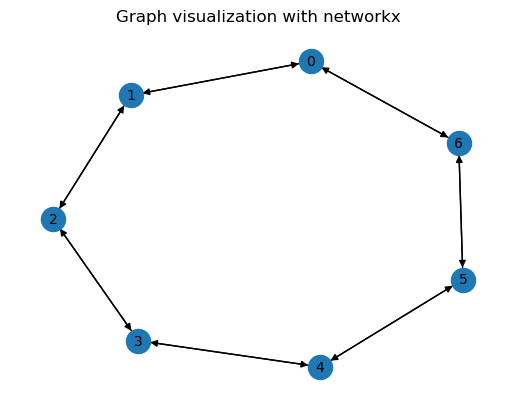

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(graph_nx, ax=ax, with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Graph visualization with networkx')
plt.show()


# Visualise graph with eigenvectors (i.e. map graph to Euclidean space)

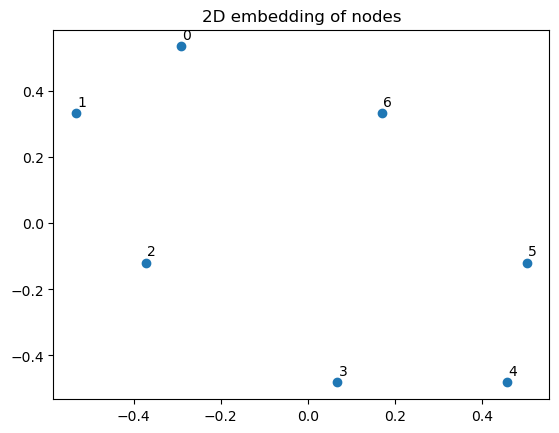

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = compute_LapEig(graph_dgl, 2)
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph_dgl.number_of_nodes()))
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


# Convert DGL graph to PyTorch tensor

In [6]:
graph_pytorch = graph_dgl.adj().to_dense() 
print(graph_pytorch)


tensor([[0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0.]])


# All type convertors

NetworkX  
https://networkx.org/documentation/stable/reference/convert.html

Sparse PyTorch  
https://pytorch.org/docs/stable/sparse.html

DGL   
https://docs.dgl.ai/api/python/dgl.sparse_v0.html#sparse-matrix-class

In [130]:
# dgl
print('# dgl\n',graph_dgl, type(graph_dgl)); print('\n')

# dgl => networkx
graph_nx = graph_dgl.to_networkx() 
print('# dgl => networkx\n',graph_nx, type(graph_nx)); print('\n')

# networkx => dgl
graph_dgl = dgl.from_networkx(graph_nx)
print('# networkx => dgl\n',graph_dgl, type(graph_dgl))
print('Note: Node and edge features must be re-generated!'); print('\n')

# networkx => (coo) sparse pytorch
# Note: edges in sparse pytorch are structured as [ list_src, list_dst ]
src=[]; dst=[]; [(src.append(edge[0]), dst.append(edge[1])) for edge in nx.to_edgelist(graph_nx)] # extract list of edges
graph_sptorch = torch.sparse_coo_tensor([src, dst], [1]*len(src), size=(num_nodes,num_nodes))
print('# networkx => (coo) sparse pytorch\n',graph_sptorch, type(graph_sptorch)); print('\n')

# (coo) sparse pytorch => networkx
# Note: edges in networkx are structure as [ list(src,dst) ]
indices = graph_sptorch.coalesce().indices()
values = graph_sptorch.coalesce().values()
src = indices[0].tolist(); dst = indices[1].tolist(); list_edges = [edge for edge in zip(src,dst)]
graph_nx = nx.Graph(list_edges) 
print('# (coo) sparse pytorch => networkx\n', graph_nx, type(graph_nx)); print('\n')

# (coo) sparse pytorch => dense pytorch
graph_pytorch = graph_sptorch.to_dense()
print('# (coo) sparse pytorch => dense pytorch\n', graph_pytorch, type(graph_pytorch)); print('\n')

# dense pytorch => (coo) sparse pytorch
graph_sptorch = graph_pytorch.to_sparse()
print('# dense pytorch => (coo) sparse pytorch\n', graph_sptorch, type(graph_sptorch)); print('\n')

# dgl => (coo) sparse pytorch 
graph_sptorch = graph_dgl.adj()
print('# dgl => (coo) sparse pytorch\n', graph_sptorch, type(graph_sptorch)); print('\n')

# dgl => (coo) sparse pytorch => dense pytorch
graph_pytorch = graph_dgl.adj().to_dense() 
print('# dgl => dense pytorch\n', graph_pytorch, type(graph_pytorch)); print('\n')



# dgl
 Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={}) <class 'dgl.heterograph.DGLGraph'>


# dgl => networkx
 MultiDiGraph with 7 nodes and 14 edges <class 'networkx.classes.multidigraph.MultiDiGraph'>


# networkx => dgl
 Graph(num_nodes=7, num_edges=14,
      ndata_schemes={}
      edata_schemes={}) <class 'dgl.heterograph.DGLGraph'>
Note: Node and edge features must be re-generated!


# networkx => (coo) sparse pytorch
 tensor(indices=tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6],
                       [1, 6, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 0, 5]]),
       values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
       size=(7, 7), nnz=14, layout=torch.sparse_coo) <class 'torch.Tensor'>


# (coo) sparse pytorch => networkx
 Graph with 7 nodes and 7 edges <class 'networkx.classes.graph.Graph'>


# (coo) sparse pytorch => dense pytorch
 tensor([[0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 